In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

d:\Program Files\anaconda3\envs\torch126\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import sys
sys.path.append("D:\\0626_temp")

from flare_preprocessing import *
from utilities import *

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
opr = opr_data_preprocessing("D:/2024_S1/ML_SEP_2402/swpc_ftp/v2_ftp_flares_1997_2024.csv")
sci = sci_data_preprocessing("D:/2024_S1/ML_SEP_2402/Sci_matched_with_assigned_ar_20100101_20240721.csv", opr)

Shape of the operation data: (25364, 9)
Shape of the science-quality data: (30958, 31)


D:\0626_temp\utilities.py:64: RuntimeWarning: divide by zero encountered in log10
  return np.log10(intensity * 10 ** -8)


## nrt sharps

In [5]:
from New_SampleConstruction import *
from New_lstm2 import *

In [9]:
from pathlib import Path

def read_all_harp_csvs(root: str | Path, recursive: bool = False) -> pd.DataFrame:
    """
    Read all per-HARP CSVs under `root`, concatenate them in ascending HARP order,
    Assumes files are named like HARP_<harpnum>.csv.
    """

    root = Path(root)
    pattern = "**/HARP_*.csv" if recursive else "HARP_*.csv"

    # List files first, sorted by HARP number
    harp_files = []
    for f in root.glob(pattern):
        try:
            harpnum = int(f.stem.split("_")[1])
            harp_files.append((harpnum, f))
        except Exception:
            continue

    # sort by numeric harp number
    harp_files.sort(key=lambda x: x[0])

    frames = []

    for harpnum, f in harp_files:
        # read with T_REC parsed as datetime
        df = pd.read_csv(f, parse_dates=["T_REC"])
        print(f"Reading HARP {harpnum}")

        # Skip if the HARP lifetime is less than 120 rows (24h / 12min cadence)
        if len(df) < 120:
            print(f"  -> Skipping HARP {harpnum} (too short)")
            continue
        # fill the HARPNUM with the harpnum
        df['HARPNUM'] = harpnum
        frames.append(df)

    if not frames:
        print("No valid HARP CSVs found.")
        return pd.DataFrame()

    # Concatenate in correct order
    full_df = pd.concat(frames, ignore_index=True)
    print(f"Loaded {len(frames)} HARPs; total rows = {len(full_df)}")
    
    return full_df

In [10]:
nrt_sharps = read_all_harp_csvs(r"D:\\Input Data\\Operational Data\\HMI\SHARP_by_HARP")

Reading HARP 476
Reading HARP 487
Reading HARP 493
Reading HARP 495
Reading HARP 497
Reading HARP 498
Reading HARP 499
  -> Skipping HARP 499 (too short)
Reading HARP 500
  -> Skipping HARP 500 (too short)
Reading HARP 501
Reading HARP 502
Reading HARP 503
Reading HARP 504
Reading HARP 505
Reading HARP 506
  -> Skipping HARP 506 (too short)
Reading HARP 508
Reading HARP 509
Reading HARP 510
Reading HARP 511
Reading HARP 512
Reading HARP 513
  -> Skipping HARP 513 (too short)
Reading HARP 514
  -> Skipping HARP 514 (too short)
Reading HARP 515
Reading HARP 516
Reading HARP 518
  -> Skipping HARP 518 (too short)
Reading HARP 520
Reading HARP 521
Reading HARP 523
Reading HARP 524
  -> Skipping HARP 524 (too short)
Reading HARP 526
Reading HARP 527
Reading HARP 529
Reading HARP 532
Reading HARP 533
  -> Skipping HARP 533 (too short)
Reading HARP 534
Reading HARP 537
Reading HARP 547
  -> Skipping HARP 547 (too short)
Reading HARP 550
Reading HARP 552
  -> Skipping HARP 552 (too short)
Read

C:\Users\huke0\AppData\Local\Temp\ipykernel_33608\2427577827.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, parse_dates=["T_REC"])


Reading HARP 11225
Reading HARP 11226
  -> Skipping HARP 11226 (too short)
Reading HARP 11227
  -> Skipping HARP 11227 (too short)
Reading HARP 11229
  -> Skipping HARP 11229 (too short)
Reading HARP 11231
  -> Skipping HARP 11231 (too short)
Reading HARP 11232
Reading HARP 11233
  -> Skipping HARP 11233 (too short)
Reading HARP 11234
  -> Skipping HARP 11234 (too short)
Reading HARP 11235
  -> Skipping HARP 11235 (too short)
Reading HARP 11237
  -> Skipping HARP 11237 (too short)
Reading HARP 11241
  -> Skipping HARP 11241 (too short)
Reading HARP 11242
Reading HARP 11243
Reading HARP 11244
  -> Skipping HARP 11244 (too short)
Reading HARP 11245
  -> Skipping HARP 11245 (too short)
Reading HARP 11246
Reading HARP 11248
Reading HARP 11249
  -> Skipping HARP 11249 (too short)
Reading HARP 11250
Reading HARP 11251
Reading HARP 11252
  -> Skipping HARP 11252 (too short)
Reading HARP 11253
Reading HARP 11255
Reading HARP 11256
  -> Skipping HARP 11256 (too short)
Reading HARP 11258
Reading

In [11]:
# delete rows with key columns any NaN values
key_columns = [
    'USFLUX','MEANGAM','MEANGBT','MEANGBZ','MEANGBH','MEANJZD',
    'TOTUSJZ','MEANALP','MEANJZH','TOTUSJH','ABSNJZH','SAVNCPP',
    'MEANPOT','TOTPOT','MEANSHR','SHRGT45','SIZE','SIZE_ACR',
    'NACR','NPIX'
]
nrt_sharps = nrt_sharps.dropna(subset=key_columns)

In [12]:
NRT_nowcasting_obj_24 = New_SampleConstruction()
NRT_nowcasting_obj_24.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=24)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [13]:
NRT_nowcasting_obj_12 = New_SampleConstruction()
NRT_nowcasting_obj_12.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=12)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [14]:
NRT_nowcasting_obj_6 = New_SampleConstruction()
NRT_nowcasting_obj_6.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=6)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

Bootstrap iteration 1/30
Epoch 1, avg loss: 1.0392055282225976
Epoch 2, avg loss: 0.9821235262430631
Epoch 3, avg loss: 0.9085759749779334
Epoch 4, avg loss: 0.8188694623800424
Epoch 5, avg loss: 0.7472546146466181
Epoch 6, avg loss: 0.6853595330164983
Epoch 7, avg loss: 0.6397969814447256
Epoch 8, avg loss: 0.6035380844886487
Epoch 9, avg loss: 0.5682169909660633
Epoch 10, avg loss: 0.5448617660082303
Epoch 11, avg loss: 0.5234444668659797
Epoch 12, avg loss: 0.48865543878995454
Epoch 13, avg loss: 0.4808046794854678
Epoch 14, avg loss: 0.4467104123188899
Epoch 15, avg loss: 0.4506990061356471
Bootstrap iteration 2/30
Epoch 1, avg loss: 1.0350294846754808
Epoch 2, avg loss: 0.9883396625518799
Epoch 3, avg loss: 0.9192252663465647
Epoch 4, avg loss: 0.8478688872777499
Epoch 5, avg loss: 0.7715603296573346
Epoch 6, avg loss: 0.7064448732596177
Epoch 7, avg loss: 0.6660378162677472
Epoch 8, avg loss: 0.6332497871839083
Epoch 9, avg loss: 0.6454928333942707
Epoch 10, avg loss: 0.657348951

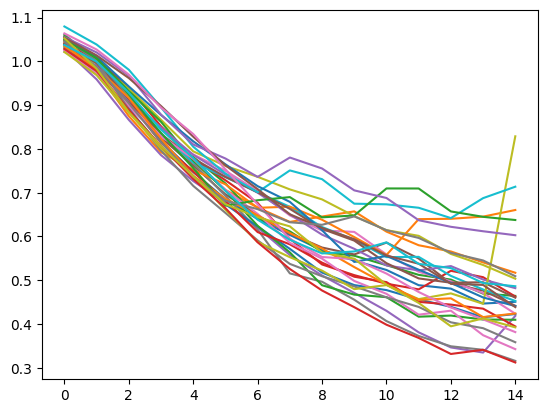

The 95% CI for threshold is 0.2 - 0.86375
The 95% CI for TSS is 0.6508389261744967 - 0.8639152319813248

[Resource Summary for 30 bootstrapped LSTM models]
Total training time: 30.11 seconds
Max CPU memory used: 3249.24 MB
Max GPU memory used: 954.05 MB


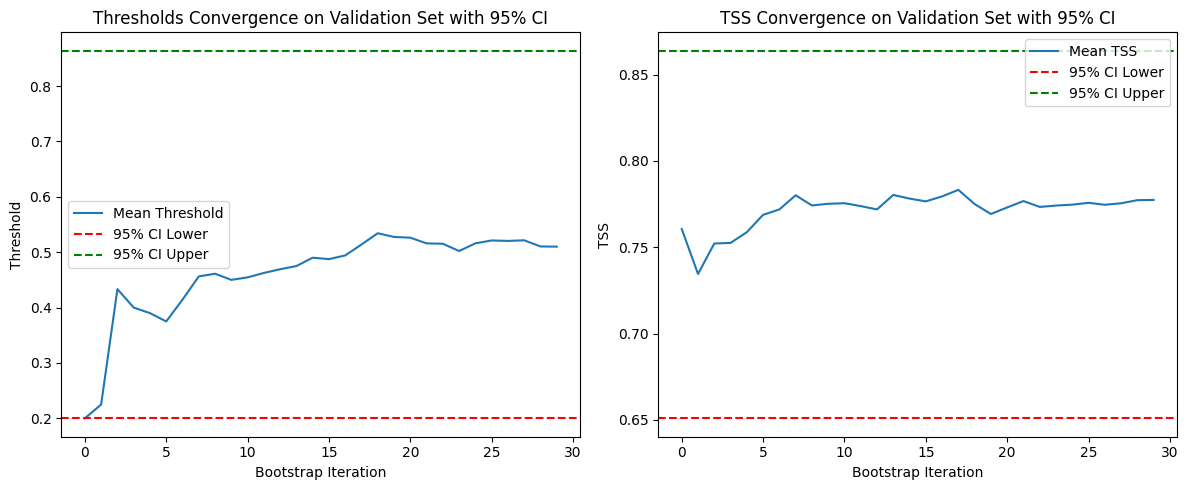

In [15]:
NRT_lead0_Mplus_24_whole = train_lstm()
NRT_lead0_Mplus_24_whole.train(NRT_nowcasting_obj_24.inputs_profile, NRT_nowcasting_obj_24.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'),n_epoch=15)

In [16]:
save_dir_nrt = ".\\LSTM_models\\Sci_nrtSHARP"

In [17]:
for i, model in enumerate(NRT_lead0_Mplus_24_whole.models):
    os.makedirs(save_dir_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_nrt, f"NRT_lead0_Mplus_24_whole{i}.pth")
    torch.save(model.state_dict(), model_path)

Bootstrap iteration 1/30
Epoch 1, avg loss: 1.0943761534161038
Epoch 2, avg loss: 1.0674428741137187
Epoch 3, avg loss: 1.0289832552274067
Epoch 4, avg loss: 0.9892341759469774
Epoch 5, avg loss: 0.9269507394896613
Epoch 6, avg loss: 0.8690685166252984
Epoch 7, avg loss: 0.8105633589956496
Epoch 8, avg loss: 0.7480638292100694
Epoch 9, avg loss: 0.6854834424124824
Epoch 10, avg loss: 0.6013540824254354
Epoch 11, avg loss: 0.5775770412551032
Epoch 12, avg loss: 0.5706446237034268
Epoch 13, avg loss: 0.5395307805803087
Epoch 14, avg loss: 0.5174769990974002
Epoch 15, avg loss: 0.502557678355111
Bootstrap iteration 2/30
Epoch 1, avg loss: 1.0686452587445576
Epoch 2, avg loss: 1.028923465145959
Epoch 3, avg loss: 0.981216185622745
Epoch 4, avg loss: 0.9119801123936971
Epoch 5, avg loss: 0.8618588116433885
Epoch 6, avg loss: 0.8175570368766785
Epoch 7, avg loss: 0.7767473194334242
Epoch 8, avg loss: 0.7324943873617384
Epoch 9, avg loss: 0.6822473274336921
Epoch 10, avg loss: 0.6482301321294

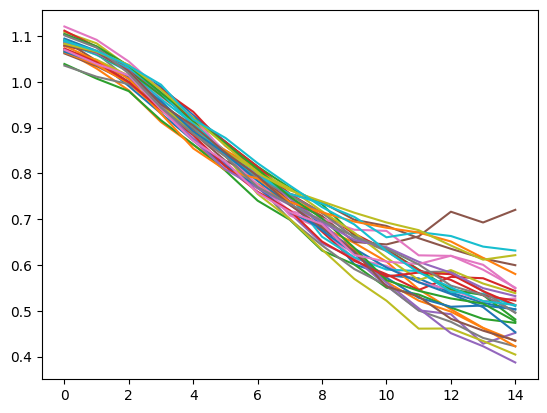

The 95% CI for threshold is 0.13625 - 0.8
The 95% CI for TSS is 0.5913627320954907 - 0.7900364721485411

[Resource Summary for 30 bootstrapped LSTM models]
Total training time: 18.53 seconds
Max CPU memory used: 3245.23 MB
Max GPU memory used: 956.05 MB


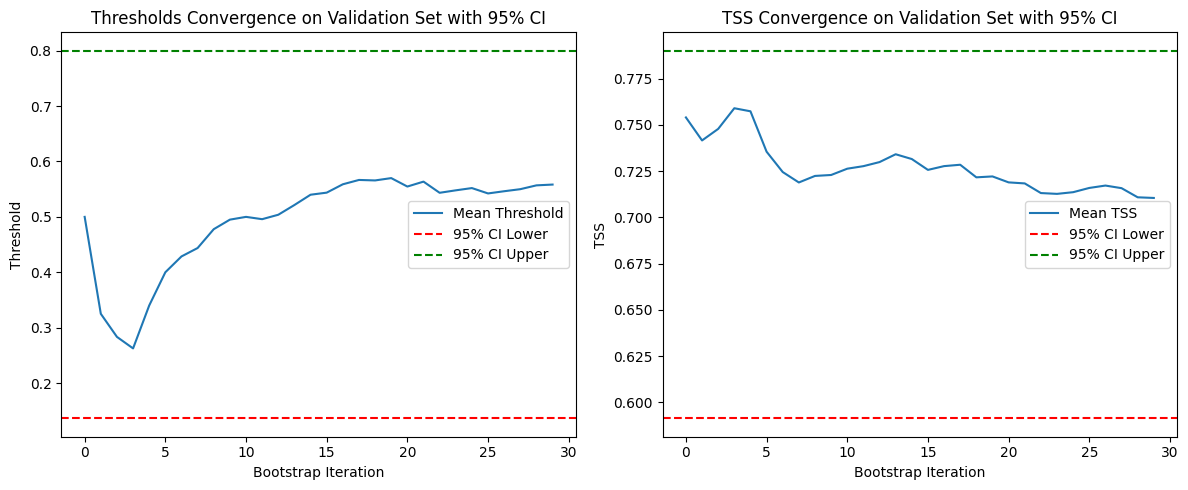

In [18]:
NRT_lead0_Mplus_12_whole = train_lstm()
NRT_lead0_Mplus_12_whole.train(NRT_nowcasting_obj_12.inputs_profile, NRT_nowcasting_obj_12.labels, "Mplus_train", pd.to_datetime('2010-01-01'), pd.to_datetime('2020-01-01'),n_epoch=15)

In [19]:
for i, model in enumerate(NRT_lead0_Mplus_12_whole.models):
    os.makedirs(save_dir_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_nrt, f"NRT_lead0_Mplus_12_whole{i}.pth")
    torch.save(model.state_dict(), model_path)

Bootstrap iteration 1/30
Epoch 1, avg loss: 1.1378239194552104
Epoch 2, avg loss: 1.1249268253644307
Epoch 3, avg loss: 1.103093405564626
Epoch 4, avg loss: 1.079557438691457
Epoch 5, avg loss: 1.0413575172424316
Epoch 6, avg loss: 1.0083571473757427
Epoch 7, avg loss: 0.9678889314333597
Epoch 8, avg loss: 0.9367271463076273
Epoch 9, avg loss: 0.9062296549479166
Epoch 10, avg loss: 0.8609883089860281
Epoch 11, avg loss: 0.8308201432228088
Epoch 12, avg loss: 0.7909301221370697
Epoch 13, avg loss: 0.7546944717566172
Epoch 14, avg loss: 0.7237782080968221
Epoch 15, avg loss: 0.696439286073049
Bootstrap iteration 2/30
Epoch 1, avg loss: 1.1232439080874126
Epoch 2, avg loss: 1.1068920493125916
Epoch 3, avg loss: 1.081471860408783
Epoch 4, avg loss: 1.0454499125480652
Epoch 5, avg loss: 1.007782111565272
Epoch 6, avg loss: 0.9584671755631765
Epoch 7, avg loss: 0.9177676836649576
Epoch 8, avg loss: 0.8865650792916616
Epoch 9, avg loss: 0.8566482563813528
Epoch 10, avg loss: 0.819918831189473

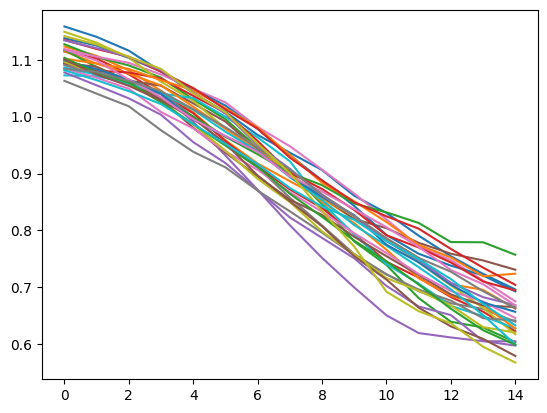

The 95% CI for threshold is 0.25 - 0.7774999999999999
The 95% CI for TSS is 0.5548319327731093 - 0.7279201680672268

[Resource Summary for 30 bootstrapped LSTM models]
Total training time: 12.48 seconds
Max CPU memory used: 3233.71 MB
Max GPU memory used: 962.05 MB


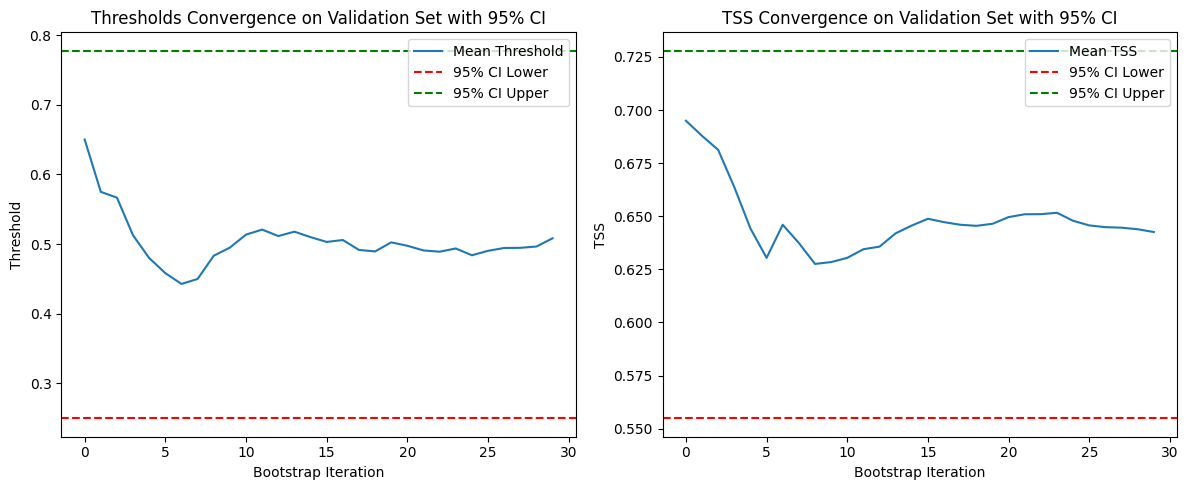

In [20]:
NRT_lead0_Mplus_6_whole = train_lstm()
NRT_lead0_Mplus_6_whole.train(NRT_nowcasting_obj_6.inputs_profile, NRT_nowcasting_obj_6.labels, "Mplus_train", pd.to_datetime('2012-09-14'), pd.to_datetime('2020-01-01'),n_epoch=15)

In [21]:
for i, model in enumerate(NRT_lead0_Mplus_6_whole.models):
    os.makedirs(save_dir_nrt, exist_ok=True)
    model_path = os.path.join(save_dir_nrt, f"NRT_lead0_Mplus_6_whole{i}.pth")
    torch.save(model.state_dict(), model_path)

In [22]:
def GenScripts(model_name, model_obj, sample_obj, time1, time2, model_dir):
    #!!!!Note, the threshold is not saved
    te_pos_inputs,te_neg_inputs = get_samples(sample_obj.inputs_profile, sample_obj.labels, "Mplus_test",  time1, time2)
    print(f"Positive: {te_pos_inputs.shape[0]}, Negative: {te_neg_inputs.shape[0]}")
    te_inputs, te_targets = combine(te_pos_inputs, te_neg_inputs)
    te_inputs = normalize2(te_inputs, te_inputs.copy())
    inputs_tensor = torch.from_numpy(te_inputs).float().to(DEVICE)
    pods = []; fars = []; tsss = []; hsss = []; f1s = []
    for i in range(30):
        thresh_i = model_obj.thresholds[i]
        path = os.path.join(model_dir, model_name+f"{i}.pth")
        model = lstm(te_inputs.shape[2]).to(DEVICE)
        state_dict = torch.load(path, map_location=DEVICE, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        with torch.no_grad():
            out = model(inputs_tensor)
            out = torch.sigmoid(out)
        y_pred_i = out.cpu().numpy().squeeze()
        y_pred_i = (y_pred_i > thresh_i).astype(int)
        tsss.append(TSS(y_pred_i, te_targets))
        pods.append(POD(y_pred_i, te_targets))
        fars.append(FAR(y_pred_i, te_targets))
        hsss.append(HSS(y_pred_i, te_targets))
        f1s.append(F1(y_pred_i, te_targets))
    pods = np.array(pods); fars = np.array(fars); tsss = np.array(tsss); hsss = np.array(hsss); f1s = np.array(f1s)
    print(f"TSS: {np.array(tsss).mean():.2f}[{np.array(tsss).min():.2f},{np.array(tsss).max():.2f}]")
    print(f"HSS: {np.array(hsss).mean():.2f}[{np.array(hsss).min():.2f},{np.array(hsss).max():.2f}]")
    print(f"POD: {np.array(pods).mean():.2f}[{np.array(pods).min():.2f},{np.array(pods).max():.2f}]")
    print(f"F1: {np.array(f1s).mean():.2f}[{np.array(f1s).min():.2f},{np.array(f1s).max():.2f}]")
    print(f"FAR: {np.array(fars).mean():.2f}[{np.array(fars).min():.2f},{np.array(fars).max():.2f}]")
    return tsss, hsss, pods, f1s, fars

## lead0, 24

In [24]:
tsss, hsss, pods, f1s, fars = GenScripts("NRT_lead0_Mplus_24_whole", NRT_lead0_Mplus_24_whole, NRT_nowcasting_obj_24, pd.to_datetime('2020-01-01'), pd.to_datetime('2022-01-01'), save_dir_nrt)

Positive: 39, Negative: 600
TSS: 0.55[0.14,0.80]
HSS: 0.17[0.04,0.41]
POD: 0.89[0.54,1.00]
F1: 0.26[0.14,0.45]
FAR: 0.34[0.06,0.44]


In [25]:
tsss, hsss, pods, f1s, fars = GenScripts("NRT_lead0_Mplus_24_whole", NRT_lead0_Mplus_24_whole, NRT_nowcasting_obj_24, pd.to_datetime('2022-01-01'), pd.to_datetime('2023-01-01'), save_dir_nrt)

Positive: 195, Negative: 208
TSS: 0.47[0.19,0.75]
HSS: 0.47[0.19,0.75]
POD: 0.61[0.24,0.85]
F1: 0.69[0.37,0.87]
FAR: 0.14[0.02,0.29]


In [26]:
tsss, hsss, pods, f1s, fars = GenScripts("NRT_lead0_Mplus_24_whole", NRT_lead0_Mplus_24_whole, NRT_nowcasting_obj_24, pd.to_datetime('2023-01-01'), pd.to_datetime('2025-01-01'), save_dir_nrt)

Positive: 392, Negative: 0


D:\0626_temp\utilities.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (TP) / (TP + FN ) - (FP) / (FP + TN )
D:\0626_temp\utilities.py:122: RuntimeWarning: invalid value encountered in scalar divide
  return FP / (TN + FP)


TSS: nan[nan,nan]
HSS: 0.00[0.00,0.00]
POD: 0.38[0.16,0.58]
F1: 0.54[0.27,0.73]
FAR: nan[nan,nan]


In [27]:
tsss, hsss, pods, f1s, fars = GenScripts("NRT_lead0_Mplus_24_whole", NRT_lead0_Mplus_24_whole, NRT_nowcasting_obj_24, pd.to_datetime('2020-01-01'), pd.to_datetime('2025-01-01'), save_dir_nrt)

Positive: 626, Negative: 808
TSS: 0.60[0.41,0.76]
HSS: 0.62[0.44,0.78]
POD: 0.69[0.43,0.81]
F1: 0.76[0.59,0.86]
FAR: 0.09[0.01,0.19]


## lead0, 12